In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os

# Thiết lập để tái tạo kết quả
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Chuẩn bị dữ liệu

In [ ]:
# Tải dữ liệu cats vs dogs
(train_ds, val_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

# Hiển thị thông tin về dataset
print("Dataset info:")
print(f"Number of classes: {info.features['label'].num_classes}")
print(f"Class names: {info.features['label'].names}")
print(f"Total examples: {info.splits['train'].num_examples}")

# Các thông số cơ bản
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 2

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.VOUKQ7_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset info:
Number of classes: 2
Class names: ['cat', 'dog']
Total examples: 23262


# Tiền xử lý dữ liệu

In [ ]:
def preprocess_image(image, label):
    """Tiền xử lý ảnh: resize và normalize"""
    # Resize ảnh về kích thước cố định
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values từ [0, 255] về [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment_image(image, label):
    """Data augmentation để tăng độ đa dạng của dữ liệu"""
    # Random flip horizontal
    image = tf.image.random_flip_left_right(image)
    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Áp dụng preprocessing
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Áp dụng data augmentation chỉ cho training set
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch và prefetch để tối ưu hiệu suất
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
def show_sample_images():
    class_names = ['Cat', 'Dog']

    plt.figure(figsize=(12, 8))
    for images, labels in train_ds.take(1):
        for i in range(min(9, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images()

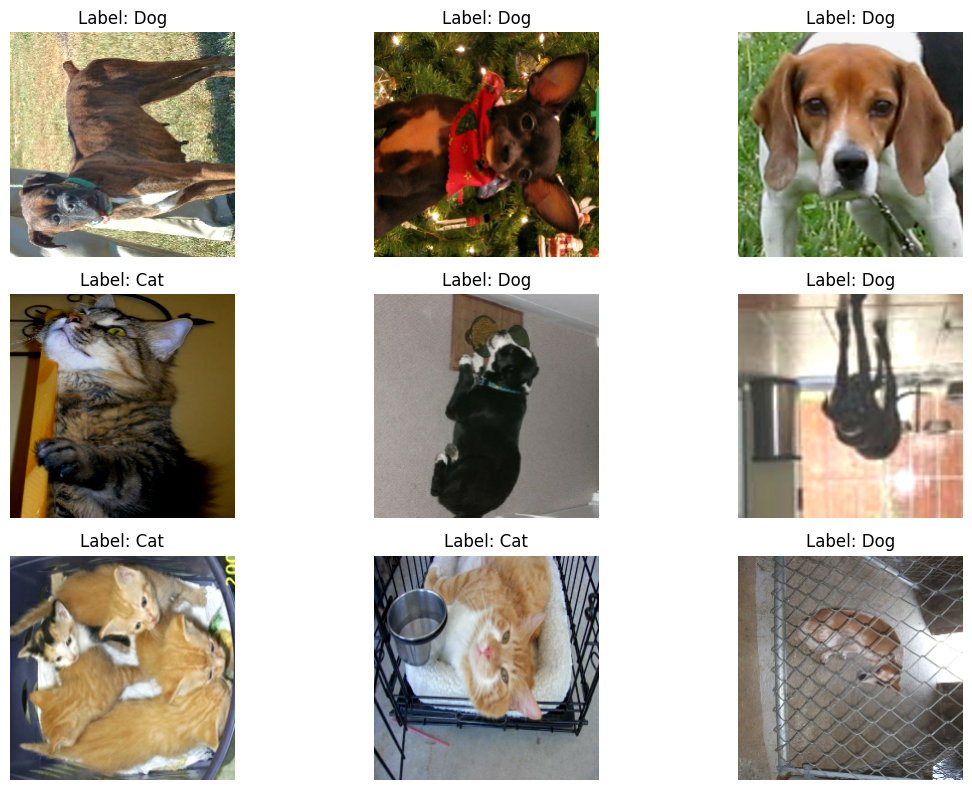

# Tạo model CNN

In [ ]:
def create_model():
    model = Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        # Dropout để tránh overfitting
        layers.Dropout(0.5),

        # Flatten và fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Sigmoid cho binary classification
    ])

    return model

model = create_model()

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model với optimizer, loss function và metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Thiết lập callbacks

In [ ]:
# Tạo thư mục để lưu model
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Callbacks
callbacks = [
    # ModelCheckpoint để lưu model tốt nhất
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_cats_dogs_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),

    # EarlyStopping để dừng training khi không cải thiện
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # ReduceLROnPlateau để giảm learning rate
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Training model

In [ ]:
# Training model
EPOCHS = 20

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5190 - loss: 0.6914
Epoch 1: val_accuracy improved from -inf to 0.58856, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.5191 - loss: 0.6914 - val_accuracy: 0.5886 - val_loss: 0.6785 - learning_rate: 0.0010
Epoch 2/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5858 - loss: 0.6718
Epoch 2: val_accuracy improved from 0.58856 to 0.67885, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.5859 - loss: 0.6718 - val_accuracy: 0.6788 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 3/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6816 - loss: 0.5961
Epoch 3: val_accuracy improved from 0.67885 to 0.70077, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - accuracy: 0.6816 - loss: 0.5960 - val_accuracy: 0.7008 - val_loss: 0.5757 - learning_rate: 0.0010
Epoch 4/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7195 - loss: 0.5472
Epoch 4: val_accuracy improved from 0.70077 to 0.70808, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.7196 - loss: 0.5472 - val_accuracy: 0.7081 - val_loss: 0.5631 - learning_rate: 0.0010
Epoch 5/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7474 - loss: 0.5179
Epoch 5: val_accuracy improved from 0.70808 to 0.73130, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.7474 - loss: 0.5178 - val_accuracy: 0.7313 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 6/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7722 - loss: 0.4811
Epoch 6: val_accuracy improved from 0.73130 to 0.74699, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.7722 - loss: 0.4811 - val_accuracy: 0.7470 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 7/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7879 - loss: 0.4619
Epoch 7: val_accuracy improved from 0.74699 to 0.77816, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.7879 - loss: 0.4618 - val_accuracy: 0.7782 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 8/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7971 - loss: 0.4370
Epoch 8: val_accuracy did not improve from 0.77816
582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.7971 - loss: 0.4370 - val_accuracy: 0.7612 - val_loss: 0.4945 - learning_rate: 0.0010
Epoch 9/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8071 - loss: 0.4237
Epoch 9: val_accuracy improved from 0.77816 to 0.79106, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.8071 - loss: 0.4237 - val_accuracy: 0.7911 - val_loss: 0.4565 - learning_rate: 0.0010
Epoch 10/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8177 - loss: 0.4039
Epoch 10: val_accuracy improved from 0.79106 to 0.81449, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.8178 - loss: 0.4038 - val_accuracy: 0.8145 - val_loss: 0.4161 - learning_rate: 0.0010
Epoch 11/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8350 - loss: 0.3762
Epoch 11: val_accuracy did not improve from 0.81449
582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.8350 - loss: 0.3762 - val_accuracy: 0.7917 - val_loss: 0.4542 - learning_rate: 0.0010
Epoch 12/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8349 - loss: 0.3652
Epoch 12: val_accuracy did not improve from 0.81449
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.8349 - loss: 0.3652 - val_accuracy: 0.7964 - val_loss: 0.4440 - learning_rate: 0.0010
Epoch 13/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8494 - loss: 0.3381
Epoch 13: val_accuracy improved from 0.81449 to 0.82954, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.8494 - loss: 0.3381 - val_accuracy: 0.8295 - val_loss: 0.3941 - learning_rate: 0.0010
Epoch 14/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8626 - loss: 0.3186
Epoch 14: val_accuracy did not improve from 0.82954
582/582 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.8626 - loss: 0.3185 - val_accuracy: 0.8164 - val_loss: 0.4336 - learning_rate: 0.0010
Epoch 15/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8596 - loss: 0.3255
Epoch 15: val_accuracy did not improve from 0.82954
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - accuracy: 0.8596 - loss: 0.3254 - val_accuracy: 0.8263 - val_loss: 0.4016 - learning_rate: 0.0010
Epoch 16/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8736 - loss: 0.3023
Epoch 16: val_accuracy improved from 0.82954 to 0.84437, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - accuracy: 0.8736 - loss: 0.3023 - val_accuracy: 0.8444 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 17/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8775 - loss: 0.3015
Epoch 17: val_accuracy did not improve from 0.84437
582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.8775 - loss: 0.3015 - val_accuracy: 0.8366 - val_loss: 0.3885 - learning_rate: 0.0010
Epoch 18/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8864 - loss: 0.2775
Epoch 18: val_accuracy did not improve from 0.84437
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.8864 - loss: 0.2775 - val_accuracy: 0.8347 - val_loss: 0.3875 - learning_rate: 0.0010
Epoch 19/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8879 - loss: 0.2668
Epoch 19: val_accuracy improved from 0.84437 to 0.85189, saving model to saved_models/best_cats_dogs_model.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.8879 - loss: 0.2668 - val_accuracy: 0.8519 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 20/20
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9018 - loss: 0.2445
Epoch 20: val_accuracy did not improve from 0.85189
582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.9018 - loss: 0.2445 - val_accuracy: 0.8424 - val_loss: 0.4071 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 19.


### Sau khi trải qua training 20 epoch thì thấy accuracy có thể tăng thêm và loss có thể tiếp tục giảm, val_accuracy và val_loss cũng đều tăng và giảm nhẹ nên ta có thể tiếp tục training và linh hoạt learning rate.

# Fine tuning

In [ ]:
model = tf.keras.models.load_model('saved_models/best_cats_dogs_model.h5')

# Setup với ReduceLROnPlateau
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # Khởi đầu vừa phải
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks thông minh
callbacks = [
    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        'saved_models/fine_tuned_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # Adaptive LR
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,           # Giảm 50% khi cần
        patience=2,           # Chờ 2 epochs
        min_lr=5e-6,          # Minimum LR
        verbose=1
    ),

    # Stop khi không cải thiện
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,           # Patience cao hơn cho fine-tuning
        restore_best_weights=True,
        verbose=1
    )
]

history_fine = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9055 - loss: 0.2347
Epoch 1: val_accuracy improved from -inf to 0.86221, saving model to saved_models/fine_tuned_best.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.9055 - loss: 0.2347 - val_accuracy: 0.8622 - val_loss: 0.3559 - learning_rate: 3.0000e-04
Epoch 2/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9180 - loss: 0.2050
Epoch 2: val_accuracy did not improve from 0.86221
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 83ms/step - accuracy: 0.9180 - loss: 0.2050 - val_accuracy: 0.8579 - val_loss: 0.3686 - learning_rate: 3.0000e-04
Epoch 3/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9204 - loss: 0.2034
Epoch 3: val_accuracy did not improve from 0.86221

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
582/582 ━━━━━━━━━━━━━━━━━━━━ 46s 79ms/step - accuracy: 0.9204 - loss: 0.2034 - val_accuracy: 0.8622 - val_loss: 0.3582 - learning_rate: 3.0000e-04
Epoch 4/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9311 - loss: 0.1836
Epoch 4: val_accuracy improved from 0.86221 to 0.86694, saving model to saved_models/fine_tuned_best.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.9312 - loss: 0.1836 - val_accuracy: 0.8669 - val_loss: 0.3536 - learning_rate: 1.5000e-04
Epoch 5/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9298 - loss: 0.1835
Epoch 5: val_accuracy did not improve from 0.86694
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.9298 - loss: 0.1834 - val_accuracy: 0.8629 - val_loss: 0.3555 - learning_rate: 1.5000e-04
Epoch 6/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9315 - loss: 0.1784
Epoch 6: val_accuracy did not improve from 0.86694

Epoch 6: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.9315 - loss: 0.1784 - val_accuracy: 0.8631 - val_loss: 0.3582 - learning_rate: 1.5000e-04
Epoch 7/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9336 - loss: 0.1670
Epoch 7: val_accuracy improved from 0.86694 to 0.86823, saving model to saved_models/fine_tuned_best.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - accuracy: 0.9336 - loss: 0.1669 - val_accuracy: 0.8682 - val_loss: 0.3678 - learning_rate: 7.5000e-05
Epoch 8/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9368 - loss: 0.1695
Epoch 8: val_accuracy improved from 0.86823 to 0.86887, saving model to saved_models/fine_tuned_best.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.9368 - loss: 0.1695 - val_accuracy: 0.8689 - val_loss: 0.3544 - learning_rate: 7.5000e-05
Epoch 9/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9369 - loss: 0.1723
Epoch 9: val_accuracy improved from 0.86887 to 0.87081, saving model to saved_models/fine_tuned_best.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9369 - loss: 0.1722 - val_accuracy: 0.8708 - val_loss: 0.3556 - learning_rate: 3.7500e-05
Epoch 10/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9363 - loss: 0.1668
Epoch 10: val_accuracy did not improve from 0.87081

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
582/582 ━━━━━━━━━━━━━━━━━━━━ 78s 77ms/step - accuracy: 0.9363 - loss: 0.1668 - val_accuracy: 0.8684 - val_loss: 0.3612 - learning_rate: 3.7500e-05
Epoch 11/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9411 - loss: 0.1555
Epoch 11: val_accuracy did not improve from 0.87081
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - accuracy: 0.9411 - loss: 0.1554 - val_accuracy: 0.8684 - val_loss: 0.3650 - learning_rate: 1.8750e-05
Epoch 12/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9411 - loss: 0.1564
Epoch 12: val_accuracy did not improve from 0.87081

Epoch 12: ReduceLROnPlateau reducing learning rate to 9.375

# Visualize kết quả training

In [ ]:
def plot_training_history(history):
    """Vẽ biểu đồ loss và accuracy trong quá trình training"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ
plot_training_history(history)

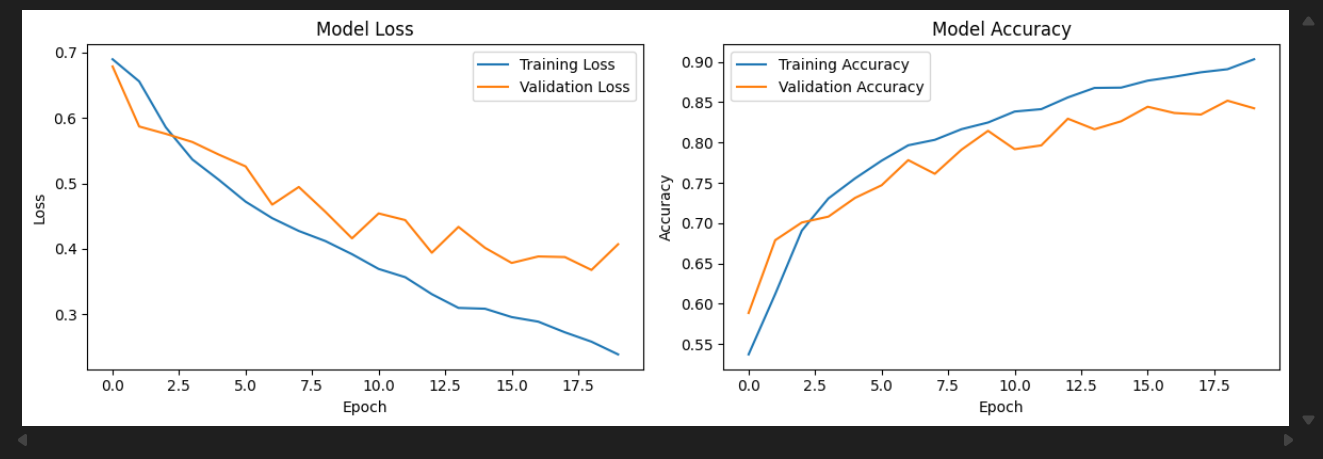

In [ ]:
plot_training_history(history_fine)

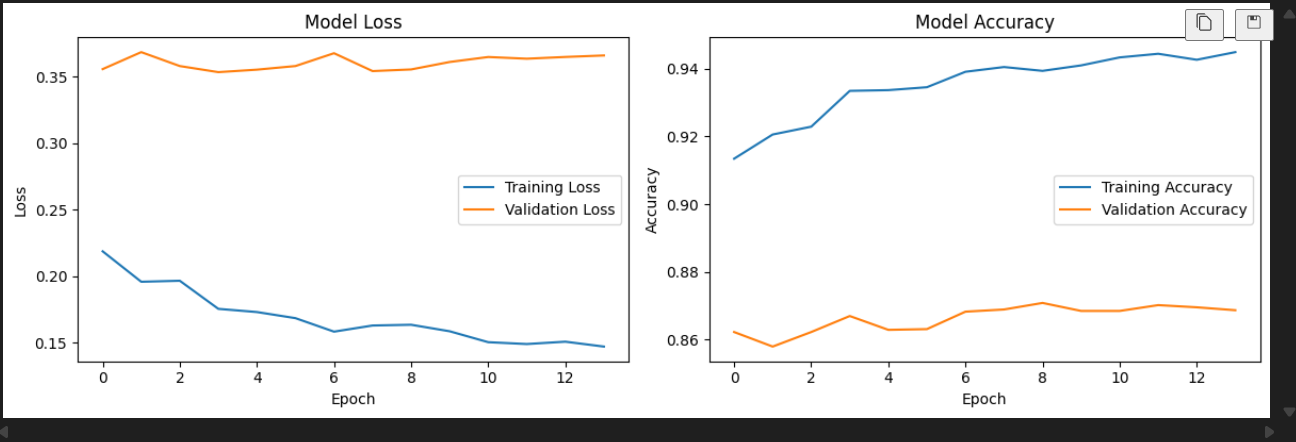

In [ ]:
# Đánh giá model trên validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
print(f"\nKết quả đánh giá trên validation set:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")


Kết quả đánh giá trên validation set:
Loss: 0.3556
Accuracy: 0.8708


# Visualize kết quả training

In [ ]:
def load_and_predict(model_path, image_path):
    """Load model đã lưu và dự đoán trên ảnh mới"""
    # Load model
    loaded_model = tf.keras.models.load_model(model_path)

    # Load và preprocess ảnh
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, 0)  # Thêm batch dimension

    # Dự đoán
    prediction = loaded_model.predict(image)
    class_names = ['Cat', 'Dog']
    predicted_class = class_names[int(prediction[0] > 0.5)]
    confidence = float(prediction[0] if prediction[0] > 0.5 else 1 - prediction[0])

    return predicted_class, confidence

# Ví dụ sử dụng (thay thế đường dẫn ảnh thực tế)
predicted_class, confidence = load_and_predict('saved_models/fine_tuned_best.h5', 'OIP.jpg')
print(f"Dự đoán: {predicted_class} với độ tin cậy {confidence:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
Dự đoán: Cat với độ tin cậy 99.94%


/tmp/ipython-input-484059509.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(prediction[0] > 0.5)]
/tmp/ipython-input-484059509.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0] if prediction[0] > 0.5 else 1 - prediction[0])
